In [1]:

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

# CONFIGURATION
METRIC = 'val/mae'  # Options: 'test/accuracy', 'test/auroc', 'test/precision', 'test/recall', etc.
VARIED_PARAMETERS = ['max_n_nodes'] #'avg_degree_range', 'homophily_range']  # Multiple experiments to analyze

# Load data from wandb
api = wandb.Api(timeout=100)

run_to_api_dict = {'avg_degree_range': 'graphuniverse/final_degree_experiments_transductive',
                   'homophily_range': 'graphuniverse/final_homophily_experiments_transductive',
                   'degree_separation_range': 'graphuniverse/final_triangle_experiments',
                   'max_n_nodes': 'graphuniverse/final_num_nodes_experiments'}

# Get all runs from all projects
all_runs = []
for varied_param in VARIED_PARAMETERS:
    print(f"Loading runs from {varied_param} experiment...")
    runs = api.runs(run_to_api_dict[varied_param])
    all_runs.extend(runs)
    print(f"  Loaded {len(runs)} runs")

print(f"Total runs loaded: {len(all_runs)}")

# Collect data from all runs
all_data = []
for run in all_runs:  # Fixed: use all_runs instead of runs
    # Get summary metrics
    summary = run.summary._json_dict
    summary['run_name'] = run.name
    summary['run_id'] = run.id
    
    # Add config parameters with 'config_' prefix to avoid name conflicts
    config = run.config
    for key, value in config.items():
        summary[f'config_{key}'] = value
    
    all_data.append(summary)

# Convert to DataFrame
df = pd.DataFrame(all_data)

/home/gbg141/.conda/envs/tb/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Loading runs from max_n_nodes experiment...
  Loaded 2253 runs
Total runs loaded: 2253


Data loaded from 1 experiment types:
experiment_type
degree_separation_range    2207
Name: count, dtype: int64
Analyzing models: ['nsd']
Total configurations: 32
Configurations by experiment type:
experiment_type
degree_separation_range    32
Name: count, dtype: int64
Calculating performance percentiles within experimental contexts...
✓ Performance percentiles calculated successfully
Percentile range: 6.2% - 100.0%
hyperparam_columns
['_target_', 'backbone__target_', 'backbone_hidden_channels', 'backbone_in_channels', 'backbone_wrapper__partial_', 'backbone_wrapper__target_', 'backbone_wrapper_num_cell_dimensions', 'backbone_wrapper_out_channels', 'backbone_wrapper_wrapper_name', 'compile', 'feature_encoder__target_', 'feature_encoder_encoder_name', 'feature_encoder_in_channels', 'feature_encoder_out_channels', 'feature_encoder_proj_dropout', 'model_domain', 'readout__target_', 'readout_act', 'readout_dropout', 'readout_final_act', 'readout_hidden_layers', 'readout_in_channels', 'reado

/tmp/ipykernel_172184/832853624.py:323: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hyperparam_df = hyperparam_df.groupby(['n_graphs', 'experiment_type', 'varied_param_value', 'model_name'], group_keys=False).apply(calculate_percentiles)
/tmp/ipykernel_172184/832853624.py:421: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(readable_labels)


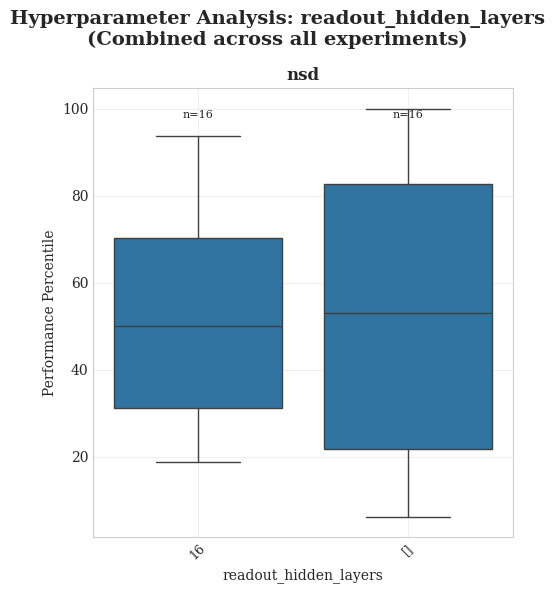

Creating plot 2/4: transform_encoding
['LapPE', 'RWSE']


/tmp/ipykernel_172184/832853624.py:421: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(readable_labels)


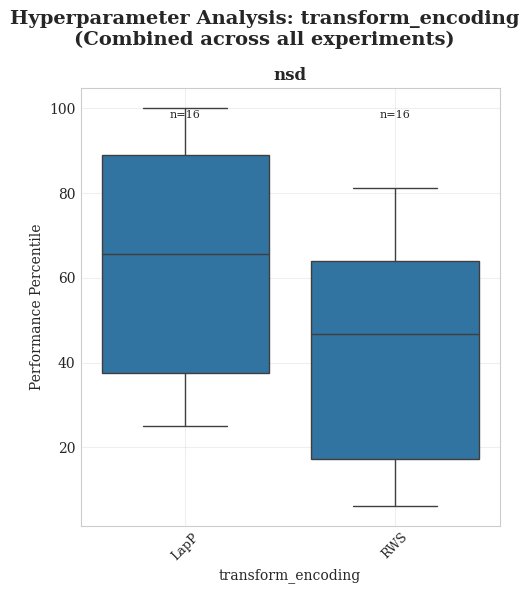

Creating plot 3/4: backbone_dropout
[0.0, 0.2]


/tmp/ipykernel_172184/832853624.py:421: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(readable_labels)


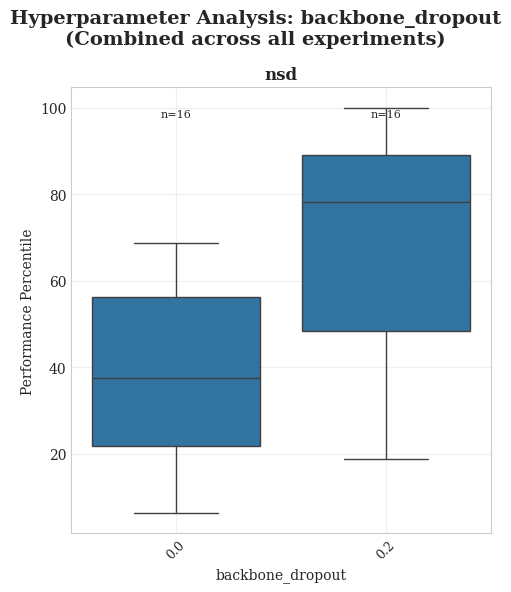

Creating plot 4/4: backbone_num_layers
[4.0, 6.0]


/tmp/ipykernel_172184/832853624.py:421: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(readable_labels)


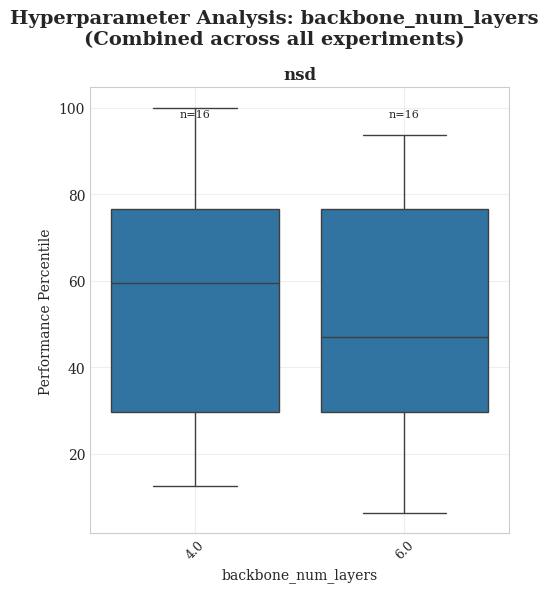


✓ All plots displayed successfully

SUMMARY STATISTICS

nsd:
  Total configurations: 32
  Performance range: 6.2% - 100.0%
  Mean percentile: 53.1%
    degree_separation_range: 32 configs, mean percentile: 53.1%

✓ Data saved to: hyperparameter_data_with_percentiles_combined_val_mae.csv

ANALYSIS COMPLETE!
Key insights from the boxplots:
- Lower percentiles = worse performance within experimental context
- Higher percentiles = better performance within experimental context
- Wide boxes = high variance in performance for that hyperparameter value
- Consistent patterns across models suggest robust hyperparameter effects
- Data combines results from all experiment types for broader insights


In [4]:
# SPECIFY WHICH MODELS TO ANALYZE
MODELS_TO_ANALYZE = ['nsd']  # Add/remove models as needed
# Available models: 'DeepSet', 'GPS', 'GraphMLP', 'GraphSAGE', 'gat', 'gcn', 'gin', 'nsd', 'topotune'

# Function to safely extract nested values
def safe_get_nested(obj, keys, default=None):
    """Safely get nested dictionary values"""
    try:
        for key in keys:
            obj = obj[key]
        return obj
    except (KeyError, TypeError, IndexError):
        return default

def extract_transform_info(config_transforms, model_name):
    """Extract relevant transform information based on model type"""
    if pd.isna(config_transforms) or config_transforms is None:
        return "no_transform"
    
    if model_name in ['GPS', 'nsd']:
        # Extract encodings for GPS and NSD
        if 'CombinedPSEs' in config_transforms:
            encodings = config_transforms['CombinedPSEs'].get('encodings', [])
            if encodings:
                return '_'.join(sorted(encodings))  # Sort for consistency
        return "no_encoding"
    
    elif model_name == 'topotune':
        return "cell_lifting"
    
    else:
        return "no_transform"

def dict_to_sorted_string(d):
    """Convert nested dict to consistent sorted string"""
    if d is None:
        return "None"
    return json.dumps(d, sort_keys=True, separators=(',', ':'))

def dict_to_sorted_string_no_seed(d, seed_keys=['seed', 'random_seed', 'random_state']):
    """Convert nested dict to consistent sorted string, excluding seed-related keys"""
    if d is None:
        return "None"
    
    def remove_seeds(obj):
        if isinstance(obj, dict):
            return {k: remove_seeds(v) for k, v in obj.items() if k not in seed_keys}
        elif isinstance(obj, list):
            return [remove_seeds(item) for item in obj]
        else:
            return obj
    
    cleaned_dict = remove_seeds(d)
    return json.dumps(cleaned_dict, sort_keys=True, separators=(',', ':'))

def flatten_dict(d, parent_key='', sep='_'):
    """Flatten nested dictionary, converting complex types to strings"""
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        elif isinstance(v, (list, tuple)):
            # Convert lists/tuples to strings for consistent handling
            items.append((new_key, str(v)))
        else:
            items.append((new_key, v))
    return dict(items)

def check_variation(series):
    """Check if a series has variation, handling complex data types"""
    try:
        return series.nunique() > 1
    except TypeError:
        # Convert to strings for comparison
        string_series = series.astype(str)
        return string_series.nunique() > 1

def create_readable_labels(values, hyperparam_name):
    """Create readable labels by extracting key differences between values"""
    if len(values) <= 1:
        return [str(v) for v in values]
    
    # Convert all to strings
    str_values = [str(v) for v in values]
    
    # For backbone_neighborhoods or similar complex parameters
    if 'backbone' in hyperparam_name.lower() or any('incidence' in str(v) for v in str_values):
        simplified = []
        for val in str_values:
            # Extract key parts: look for patterns like "incidence_X" or "laplacian_Y"
            if 'incidence' in val:
                # Extract the number after incidence
                parts = val.split('incidence')
                if len(parts) > 1:
                    suffix = parts[1].split(',')[0].split(']')[0].strip('_,] ')
                    simplified.append(f"inc_{suffix}")
                else:
                    simplified.append("inc")
            elif 'laplacian' in val:
                # Extract the number after laplacian  
                parts = val.split('laplacian')
                if len(parts) > 1:
                    suffix = parts[1].split(',')[0].split(']')[0].strip('_,] ')
                    simplified.append(f"lap_{suffix}")
                else:
                    simplified.append("lap")
            else:
                # Take first few characters if no clear pattern
                simplified.append(val[:8] + "..." if len(val) > 8 else val)
        return simplified
    
    # For other parameters, try to find common prefixes/suffixes and remove them
    if len(str_values) > 1:
        # Find common prefix
        common_prefix = ""
        for i in range(min(len(s) for s in str_values)):
            if all(s[i] == str_values[0][i] for s in str_values):
                common_prefix += str_values[0][i]
            else:
                break
        
        # Find common suffix
        common_suffix = ""
        for i in range(1, min(len(s) for s in str_values) + 1):
            if all(s[-i] == str_values[0][-i] for s in str_values):
                common_suffix = str_values[0][-i] + common_suffix
            else:
                break
        
        # Remove common parts and truncate
        simplified = []
        for val in str_values:
            shortened = val[len(common_prefix):]
            if common_suffix:
                shortened = shortened[:-len(common_suffix)]
            if not shortened:  # If nothing left, use original but truncated
                shortened = val[:10] + "..." if len(val) > 10 else val
            elif len(shortened) > 15:
                shortened = shortened[:12] + "..."
            simplified.append(shortened)
        return simplified
    
    return str_values
    
# Create string representations for sorting
df['generation_params_str'] = df['config_dataset'].apply(
    lambda x: dict_to_sorted_string(safe_get_nested(x, ['loader', 'parameters', 'generation_parameters']))
)

df['model_name'] = df['config_model'].apply(
    lambda x: safe_get_nested(x, ['model_name'])
)

# Create model config strings WITHOUT random seeds
df['model_config_str'] = df['config_model'].apply(
    lambda x: dict_to_sorted_string_no_seed(x)
)

# Extract transform info separately
df['transform_info'] = df.apply(
    lambda row: extract_transform_info(row['config_transforms'], row['model_name']), 
    axis=1
)

# Sort by generation parameters first, then model name second
df_sorted = df.sort_values(['generation_params_str', 'model_name'])

# Filter out rows with missing essential data
df_clean = df_sorted.dropna(subset=['generation_params_str', 'model_config_str', METRIC])
df_clean = df_clean[df_clean['generation_params_str'] != "None"]

# Extract parameters for ALL varied parameters
def extract_all_params(gen_params_str, varied_params):
    try:
        parsed = json.loads(gen_params_str)
        n_graphs = parsed['family_parameters']['n_graphs']
        
        # Extract all varied parameters
        result = {'n_graphs': n_graphs}
        for param in varied_params:
            if param in parsed['family_parameters']:
                result[param] = tuple(parsed['family_parameters'][param])
            else:
                result[param] = None
        return result
    except:
        return {param: None for param in ['n_graphs'] + varied_params}

# Apply parameter extraction
param_data = df_clean['generation_params_str'].apply(
    lambda x: extract_all_params(x, VARIED_PARAMETERS)
)

# Convert to DataFrame and join
param_df = pd.DataFrame(param_data.tolist())
df_clean = pd.concat([df_clean.reset_index(drop=True), param_df], axis=1)

# Create a combined experiment identifier based on which project the run came from
# We need to map run_id back to which experiment it came from
run_to_experiment = {}

# Reload runs to track which experiment each run belongs to
for varied_param in VARIED_PARAMETERS:
    runs = api.runs(run_to_api_dict[varied_param])
    for run in runs:
        run_to_experiment[run.id] = varied_param

# Map experiment type based on run_id
df_clean['experiment_type'] = df_clean['run_id'].map(run_to_experiment)

# Drop rows where we couldn't identify the experiment type
df_clean = df_clean.dropna(subset=['experiment_type'])

print(f"Data loaded from {df_clean['experiment_type'].nunique()} experiment types:")
print(df_clean['experiment_type'].value_counts())

# ============= HYPERPARAMETER ANALYSIS SECTION =============

def extract_model_hyperparams(model_config_str):
    """Extract model hyperparameters from config string"""
    try:
        config = json.loads(model_config_str)
        return config
    except:
        return {}

# Create comprehensive hyperparameter analysis DataFrame
hyperparam_results = []

# Group by all relevant factors (now including experiment type)
grouping_columns = ['model_name', 'model_config_str', 'n_graphs', 'experiment_type']

# Add the specific varied parameter for this experiment
for _, row in df_clean.iterrows():
    exp_type = row['experiment_type']
    varied_param_value = row[exp_type] if pd.notna(row[exp_type]) else None
    
    if varied_param_value is not None:
        # Calculate statistics for this configuration
        model_name = row['model_name']
        model_config_str = row['model_config_str']
        n_graphs = row['n_graphs']
        
        # Include transform_info in the grouping to make it part of the configuration
        config_key = (model_name, model_config_str, n_graphs, exp_type, varied_param_value, row['transform_info'])

        # Find all runs with this exact configuration INCLUDING transform info
        matching_runs = df_clean[
            (df_clean['model_name'] == model_name) &
            (df_clean['model_config_str'] == model_config_str) &
            (df_clean['n_graphs'] == n_graphs) &
            (df_clean['experiment_type'] == exp_type) &
            (df_clean[exp_type] == varied_param_value) &
            (df_clean['transform_info'] == row['transform_info'])
        ]
        
        if len(matching_runs) > 0 and METRIC in matching_runs.columns:
            metric_values = matching_runs[METRIC].dropna()
            
            if len(metric_values) > 0:
                mean_performance = metric_values.mean()
                std_performance = metric_values.std() if len(metric_values) > 1 else 0.0
                count = len(metric_values)
                
                # Extract and flatten model hyperparameters
                model_hyperparams = extract_model_hyperparams(model_config_str)
                flattened_hyperparams = flatten_dict(model_hyperparams)
                
                # Create result record
                result = {
                    'model_name': model_name,
                    'n_graphs': n_graphs,
                    'experiment_type': exp_type,
                    'varied_param_value': varied_param_value,
                    f'{METRIC}_mean': mean_performance,
                    f'{METRIC}_std': std_performance,
                    'n_runs': count,
                    'model_config_str': model_config_str,  # Keep original for reference
                }
                
                # Add all flattened hyperparameters
                result.update(flattened_hyperparams)

                # Add transform info as a hyperparameter
                result['transform_encoding'] = row['transform_info']
                
                # Check if we already have this exact configuration
                if not any(
                    r['model_name'] == model_name and 
                    r['model_config_str'] == model_config_str and 
                    r['n_graphs'] == n_graphs and 
                    r['experiment_type'] == exp_type and 
                    r['varied_param_value'] == varied_param_value and
                    r['transform_encoding'] == row['transform_info']
                    for r in hyperparam_results
                ):
                    hyperparam_results.append(result)

# Convert to DataFrame
hyperparam_df = pd.DataFrame(hyperparam_results)

# Filter for specified models only
hyperparam_df = hyperparam_df[hyperparam_df['model_name'].isin(MODELS_TO_ANALYZE)]

print(f"Analyzing models: {MODELS_TO_ANALYZE}")
print(f"Total configurations: {len(hyperparam_df)}")
print(f"Configurations by experiment type:")
print(hyperparam_df['experiment_type'].value_counts())

# ============= ADD PERCENTILE RANKINGS =============
# Calculate percentile within each (n_graphs, experiment_type, varied_param_value, model_architecture) combination

def calculate_percentiles(group):
    """Calculate percentile rank for each configuration within the group"""
    group = group.copy()  # Avoid SettingWithCopyWarning
    group['performance_percentile'] = group[f'{METRIC}_mean'].rank(pct=True) * 100
    return group

print("Calculating performance percentiles within experimental contexts...")

# Group by experimental config and architecture, then calculate percentiles
hyperparam_df = hyperparam_df.groupby(['n_graphs', 'experiment_type', 'varied_param_value', 'model_name'], group_keys=False).apply(calculate_percentiles)

# Reset index to ensure clean DataFrame
hyperparam_df = hyperparam_df.reset_index(drop=True)

# Verify the column was added
if 'performance_percentile' in hyperparam_df.columns:
    print(f"✓ Performance percentiles calculated successfully")
    print(f"Percentile range: {hyperparam_df['performance_percentile'].min():.1f}% - {hyperparam_df['performance_percentile'].max():.1f}%")
else:
    print("⚠ Warning: performance_percentile column not created properly")

# ============= IDENTIFY VARYING HYPERPARAMETERS =============

# Identify hyperparameters that vary across configurations
hyperparam_columns = [col for col in hyperparam_df.columns 
                     if col not in ['model_name', 'n_graphs', 'experiment_type', 'varied_param_value',
                                   f'{METRIC}_mean', f'{METRIC}_std', 'n_runs', 'model_config_str', 'performance_percentile']]

print("hyperparam_columns")
print(hyperparam_columns)

varying_hyperparams = []
for col in hyperparam_columns:
    if check_variation(hyperparam_df[col]):  # Only include hyperparams that actually vary
        varying_hyperparams.append(col)

print(f"\nHyperparameters that vary across configurations: {len(varying_hyperparams)}")
print(varying_hyperparams)

# ============= CREATE BOXPLOTS FOR EACH HYPERPARAMETER =============

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 10,
    'font.family': 'serif',
    'axes.linewidth': 0.8,
    'figure.dpi': 100
})

def create_boxplot_for_hyperparam(hyperparam, data, models):
    """Create a boxplot showing hyperparam values vs performance percentiles"""
    
    # Prepare data for plotting
    plot_data = []
    
    for model in models:
        model_data = data[data['model_name'] == model]
        if len(model_data) == 0:
            continue
            
        # Get unique values for this hyperparameter
        unique_values = sorted(model_data[hyperparam].unique())
        print(unique_values)
        
        for value in unique_values:
            value_data = model_data[model_data[hyperparam] == value]
            percentiles = value_data['performance_percentile'].values
            
            for percentile in percentiles:
                plot_data.append({
                    'model': model,
                    'hyperparam_value': str(value),
                    'performance_percentile': percentile,
                    'hyperparam': hyperparam
                })
    
    if len(plot_data) == 0:
        return None
        
    plot_df = pd.DataFrame(plot_data)
    
    # Determine subplot layout
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 6))
    if n_models == 1:
        axes = [axes]
    
    for i, model in enumerate(models):
        ax = axes[i]
        model_plot_data = plot_df[plot_df['model'] == model]
        
        if len(model_plot_data) > 0:
            # Create boxplot
            unique_values = sorted(model_plot_data['hyperparam_value'].unique())
            
            if len(unique_values) > 1:
                # Use seaborn for better boxplots
                sns.boxplot(data=model_plot_data, x='hyperparam_value', y='performance_percentile', ax=ax)
                
                # Customize plot
                ax.set_title(f'{model}', fontsize=12, fontweight='bold')
                ax.set_xlabel(f'{hyperparam}', fontsize=10)
                ax.set_ylabel('Performance Percentile' if i == 0 else '', fontsize=10)
                
                # Create more readable labels
                readable_labels = create_readable_labels(unique_values, hyperparam)
                ax.set_xticklabels(readable_labels)
                
                # Improve x-axis labels
                if len(unique_values) > 5:  # For many categories, use vertical rotation
                    ax.tick_params(axis='x', rotation=90, labelsize=8)
                else:  # For few categories, use 45-degree rotation
                    ax.tick_params(axis='x', rotation=45, labelsize=9)
                
                ax.grid(True, alpha=0.3)
                
                # Add sample size annotations
                for j, value in enumerate(unique_values):
                    count = len(model_plot_data[model_plot_data['hyperparam_value'] == value])
                    ax.text(j, ax.get_ylim()[1] - 5, f'n={count}', ha='center', va='top', fontsize=8)
            else:
                ax.text(0.5, 0.5, f'Only one value:\n{unique_values[0]}', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=10)
                ax.set_title(f'{model}', fontsize=12, fontweight='bold')
        else:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes, fontsize=10)
            ax.set_title(f'{model}', fontsize=12, fontweight='bold')
    
    plt.suptitle(f'Hyperparameter Analysis: {hyperparam}\n(Combined across all experiments)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    return fig

# Create plots for all varying hyperparameters
print(f"\n{'='*80}")
print("CREATING BOXPLOTS FOR HYPERPARAMETERS")
print(f"{'='*80}")

for i, hyperparam in enumerate(varying_hyperparams):
    print(f"Creating plot {i+1}/{len(varying_hyperparams)}: {hyperparam}")
    
    fig = create_boxplot_for_hyperparam(hyperparam, hyperparam_df, MODELS_TO_ANALYZE)
    
    if fig is not None:
        # Show the plot
        plt.show()
        
        plt.close(fig)
    else:
        print(f"  ⚠ No data available for {hyperparam}")

print(f"\n✓ All plots displayed successfully")

# ============= SUMMARY STATISTICS =============

print(f"\n{'='*80}")
print("SUMMARY STATISTICS")
print(f"{'='*80}")

for model in MODELS_TO_ANALYZE:
    model_data = hyperparam_df[hyperparam_df['model_name'] == model]
    print(f"\n{model}:")
    print(f"  Total configurations: {len(model_data)}")
    print(f"  Performance range: {model_data['performance_percentile'].min():.1f}% - {model_data['performance_percentile'].max():.1f}%")
    print(f"  Mean percentile: {model_data['performance_percentile'].mean():.1f}%")
    
    # Break down by experiment type
    for exp_type in model_data['experiment_type'].unique():
        exp_data = model_data[model_data['experiment_type'] == exp_type]
        print(f"    {exp_type}: {len(exp_data)} configs, mean percentile: {exp_data['performance_percentile'].mean():.1f}%")

# Save the data with percentiles for further analysis
output_filename = f'hyperparameter_data_with_percentiles_combined_{METRIC.replace("/", "_")}.csv'
hyperparam_df.to_csv(output_filename, index=False)
print(f"\n✓ Data saved to: {output_filename}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("Key insights from the boxplots:")
print("- Lower percentiles = worse performance within experimental context")
print("- Higher percentiles = better performance within experimental context") 
print("- Wide boxes = high variance in performance for that hyperparameter value")
print("- Consistent patterns across models suggest robust hyperparameter effects")
print("- Data combines results from all experiment types for broader insights")

In [8]:
a = ["['1-up_laplacian-0', '1-down_incidence-1', '1-down_laplacian-1', '1-up_laplacian-1', '1-down_incidence-2', '1-down_laplacian-2']", "['1-up_laplacian-0', '1-down_incidence-1', '1-up_laplacian-1', '1-down_incidence-2']", "['1-up_laplacian-0', '1-down_incidence-2']", "['1-up_laplacian-0', '1-down_laplacian-1', '1-up_laplacian-1', '1-down_laplacian-2']", "['1-up_laplacian-0', '1-down_laplacian-1']", "['1-up_laplacian-0', '1-down_laplacian-2']", "['1-up_laplacian-0', '1-up_incidence-0', '1-down_incidence-1', '1-down_laplacian-1', '1-up_laplacian-1', '1-up_incidence-1', '1-down_incidence-2', '1-down_laplacian-2']", "['1-up_laplacian-0', '1-up_incidence-0', '1-down_laplacian-1', '1-up_laplacian-1', '1-up_incidence-1', '1-down_laplacian-2']", "['1-up_laplacian-0', '1-up_incidence-0', '1-up_laplacian-1', '1-up_incidence-1']", "['1-up_laplacian-0', '1-up_laplacian-1']"]


In [14]:
for elem in a:
    print(elem)

['1-up_laplacian-0', '1-down_incidence-1', '1-down_laplacian-1', '1-up_laplacian-1', '1-down_incidence-2', '1-down_laplacian-2']
['1-up_laplacian-0', '1-down_incidence-1', '1-up_laplacian-1', '1-down_incidence-2']
['1-up_laplacian-0', '1-down_incidence-2']
['1-up_laplacian-0', '1-down_laplacian-1', '1-up_laplacian-1', '1-down_laplacian-2']
['1-up_laplacian-0', '1-down_laplacian-1']
['1-up_laplacian-0', '1-down_laplacian-2']
['1-up_laplacian-0', '1-up_incidence-0', '1-down_incidence-1', '1-down_laplacian-1', '1-up_laplacian-1', '1-up_incidence-1', '1-down_incidence-2', '1-down_laplacian-2']
['1-up_laplacian-0', '1-up_incidence-0', '1-down_laplacian-1', '1-up_laplacian-1', '1-up_incidence-1', '1-down_laplacian-2']
['1-up_laplacian-0', '1-up_incidence-0', '1-up_laplacian-1', '1-up_incidence-1']
['1-up_laplacian-0', '1-up_laplacian-1']


In [13]:
a[2], a[5], a[8], a[9]

("['1-up_laplacian-0', '1-down_incidence-2']",
 "['1-up_laplacian-0', '1-down_laplacian-2']",
 "['1-up_laplacian-0', '1-up_incidence-0', '1-up_laplacian-1', '1-up_incidence-1']",
 "['1-up_laplacian-0', '1-up_laplacian-1']")